In [1]:
# PyTorch and model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
from tqdm.notebook import tqdm
import numpy as np
import random

# TensorBoard
from torch.utils.tensorboard import SummaryWriter
import subprocess
import webbrowser
from datetime import datetime
import time

# File I/O
import os
from PIL import Image
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Human Motion Database 51 (HMDB51) Frames Model (Transfer Learning)

## Define constants and set seed

In [2]:
# Training and evaluation
BATCH_SIZE = 32
LEARNING_RATE = 0.001
LEARNING_RATE_ADAPT_STEP = 5
LEARNING_RATE_ADAPT_GAMMA = 0.5
LEARNING_RATE_ADAPT_MIN = LEARNING_RATE / 10  # for cyclical learning rate schedule only
LEARNING_RATE_ADAPT_MAX = LEARNING_RATE  # for cyclical learning rate schedule only
EPOCHS = 30
IMAGE_SIZE = (224, 224)
DEVICE = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {DEVICE}")

# TensorBoard
TENSORBOARD_TRACKING = False
TENSORBOARD_NOT_OPEN = TENSORBOARD_TRACKING

# Seed
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Device: cuda


## Prepare dataset

### Load train, validation, and test splits and create file variations of first, middle, and last frame selection

In [3]:
def input_list_from_file(file_path):
    list = []
    with open(file_path, "r") as f:
        for item in f:
            list.append(item.strip())
    return list

In [4]:
# Input training and validation set
train_val_files = input_list_from_file(os.path.join("HMDB51", "train_val_files.txt"))
train_val_labels = input_list_from_file(os.path.join("HMDB51", "train_val_labels.txt"))
train_files = input_list_from_file(os.path.join("HMDB51", "train_files.txt"))
train_labels = input_list_from_file(os.path.join("HMDB51", "train_labels.txt"))
val_files = input_list_from_file(os.path.join("HMDB51", "val_files.txt"))
val_labels = input_list_from_file(os.path.join("HMDB51", "val_labels.txt"))
# Input test set
test_files = input_list_from_file(os.path.join("HMDB51", "test_files.txt"))
test_labels = input_list_from_file(os.path.join("HMDB51", "test_labels.txt"))

# Create file variations of first, middle, and last frame
train_val_files_first = [file.split(".")[0] + "_first.png" for file in train_val_files]
train_val_files_middle = [file.split(".")[0] + "_middle.png" for file in train_val_files]
train_val_files_last = [file.split(".")[0] + "_last.png" for file in train_val_files]

train_files_first = [file.split(".")[0] + "_first.png" for file in train_files]
train_files_middle = [file.split(".")[0] + "_middle.png" for file in train_files]
train_files_last = [file.split(".")[0] + "_last.png" for file in train_files]

val_files_first = [file.split(".")[0] + "_first.png" for file in val_files]
val_files_middle = [file.split(".")[0] + "_middle.png" for file in val_files]
val_files_last = [file.split(".")[0] + "_last.png" for file in val_files]

test_files_first = [file.split(".")[0] + "_first.png" for file in test_files]
test_files_middle = [file.split(".")[0] + "_middle.png" for file in test_files]
test_files_last = [file.split(".")[0] + "_last.png" for file in test_files]


# Map action categories to 0-11 labels
action_categories = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse",
        "run", "shoot_bow", "smoke", "throw", "wave"]
action_categories_map = {action: idx for idx, action in enumerate(action_categories)}
action_categories_map_inv = {idx: action  for idx, action in enumerate(action_categories)}
train_val_labels_mapped = [action_categories_map[label] for label in train_val_labels]
train_labels_mapped = [action_categories_map[label] for label in train_labels]
val_labels_mapped = [action_categories_map[label] for label in val_labels]
test_labels_mapped = [action_categories_map[label] for label in test_labels]

### Define data transformations

In [5]:
class SquarePad:
    def __call__(self, img):
        max_size = max(img.size)

        pad_left = (max_size - img.size[0]) // 2
        pad_top = (max_size - img.size[1]) // 2

        # Account for odd sizes
        pad_right = max_size - (img.size[0] + pad_left)
        pad_bottom = max_size - (img.size[1] + pad_top)

        return transforms.functional.pad(img, (pad_left, pad_top, pad_right, pad_bottom), 0, "constant")

In [6]:
train_val_transforms = transforms.Compose([
    SquarePad(),
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAutocontrast(p=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    SquarePad(),
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    # ImageNet normalization
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define custom dataset and create data loaders for every frame selection

In [7]:
class HMDB51FramesDataset(Dataset):
    def __init__(self, files, labels, labels_map, frames_path, transform=None):
        self.files = files
        self.labels = labels
        self.labels_map = labels_map
        self.frames_path = frames_path
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        label = self.labels[index]
        
        frame_name = self.files[index]
        frame_label = self.labels_map[label]
        frame_path = os.path.join(self.frames_path, frame_label, frame_name)
        frame = Image.open(frame_path).convert("RGB")
        if self.transform:
            frame = self.transform(frame)

        return frame, label

In [8]:
frames_path = os.path.join("HMDB51", "frame_data")

train_val_first_dataset = HMDB51FramesDataset(train_val_files_first, train_val_labels_mapped,
                                              action_categories_map_inv, frames_path, transform=train_val_transforms)
train_val_middle_dataset = HMDB51FramesDataset(train_val_files_middle, train_val_labels_mapped,
                                               action_categories_map_inv, frames_path, transform=train_val_transforms)
train_val_last_dataset = HMDB51FramesDataset(train_val_files_last, train_val_labels_mapped,
                                             action_categories_map_inv, frames_path, transform=train_val_transforms)

train_first_dataset = HMDB51FramesDataset(train_files_first, train_labels_mapped,
                                          action_categories_map_inv, frames_path, transform=train_val_transforms)
train_middle_dataset = HMDB51FramesDataset(train_files_middle, train_labels_mapped,
                                           action_categories_map_inv, frames_path, transform=train_val_transforms)
train_last_dataset = HMDB51FramesDataset(train_files_last, train_labels_mapped,
                                         action_categories_map_inv, frames_path, transform=train_val_transforms)

val_first_dataset = HMDB51FramesDataset(val_files_first, val_labels_mapped,
                                        action_categories_map_inv, frames_path, transform=train_val_transforms)
val_middle_dataset = HMDB51FramesDataset(val_files_middle, val_labels_mapped,
                                         action_categories_map_inv, frames_path, transform=train_val_transforms)
val_last_dataset = HMDB51FramesDataset(val_files_last, val_labels_mapped,
                                       action_categories_map_inv, frames_path, transform=train_val_transforms)

test_first_dataset = HMDB51FramesDataset(test_files_first, test_labels_mapped,
                                         action_categories_map_inv, frames_path, transform=train_val_transforms)
test_middle_dataset = HMDB51FramesDataset(test_files_middle, test_labels_mapped,
                                          action_categories_map_inv, frames_path, transform=train_val_transforms)
test_last_dataset = HMDB51FramesDataset(test_files_last, test_labels_mapped,
                                        action_categories_map_inv, frames_path, transform=train_val_transforms)

train_val_first_loader = DataLoader(train_val_first_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_val_middle_loader = DataLoader(train_val_middle_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_val_last_loader = DataLoader(train_val_last_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_first_loader = DataLoader(train_first_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_middle_loader = DataLoader(train_middle_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_last_loader = DataLoader(train_last_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_first_loader = DataLoader(val_first_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_middle_loader = DataLoader(val_middle_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_last_loader = DataLoader(val_last_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_first_loader = DataLoader(test_first_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_middle_loader = DataLoader(test_middle_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_last_loader = DataLoader(test_last_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Load pre-trained Stanford40 Frames Model, fine-tune it on middle frame data, and evaluate it

### Import pre-trained model, freeze first layers for transfer learning, and show summary

In [9]:
def freeze_model_layers(model, trainable_layers=None):
    """
    Freezes all model layers except selection of trainable layers.

    :param model: model
    :param trainable_layers: unfrozen trainable layers
    :return: returns model with frozen layers
    """
    for name, param in model.named_parameters():
        if trainable_layers is not None and not any(layer in name for layer in trainable_layers):
            param.requires_grad = False
        else:
            param.requires_grad = True

    return model

In [10]:
spatial_hmdb51 = torch.jit.load(os.path.join("models", "spatial_stanford40_cyclical.pt"))

# Keep only some convolution layers and dense layer unfrozen
spatial_hmdb51 = freeze_model_layers(spatial_hmdb51, trainable_layers=["layer2", "layer3", "layer4", "fc"])

summary(model=spatial_hmdb51, input_size=(BATCH_SIZE, 3, *IMAGE_SIZE),
        col_width=20, col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (RecursiveScriptModule)           --                   --                   --                   Partial
├─Conv2d (conv1)                         --                   --                   (9,408)              False
├─BatchNorm2d (bn1)                      --                   --                   (128)                False
├─ReLU (relu)                            --                   --                   --                   --
├─MaxPool2d (maxpool)                    --                   --                   --                   --
├─Sequential (layer1)                    --                   --                   --                   False
│    └─BasicBlock (0)                    --                   --                   --                   False
│    │    └─Conv2d (conv1)               --                   --                   (36,864)             False
│    │    

### Train and validate model

In [11]:
def train_model_multiclass(model, num_classes, train_loader, validation_loader=None, device="cpu", epochs=15, lr=0.001,
                           adapt_lr="step", adapt_lr_step=5, adapt_lr_gamma=0.5, adapt_lr_max=-1,
                           tensorboard_tracking=False, experiment_name="Multiclass Classification", model_name=None):
    """
    Trains a model for multiclass classification.

    :param model: model
    :param num_classes: number of classes
    :param train_loader: training data loader
    :param validation_loader: validation data loader, if None then no validation
    :param device: device choice
    :param epochs: number of epochs
    :param lr: learning rate
    :param adapt_lr: "step" to adapt learning rate after certain amount of steps,
                     "cyclical" to create cyclical learning rate schedule,
                     otherwise static learning rate
    :param adapt_lr_step: number of epochs to change learning rate after if adapt_lr is "step" or "cyclical"
    :param adapt_lr_gamma: learning rate adaptation gamma if adapt_lr is "step" or "cyclical"
    :param adapt_lr_max: max learning rate in cycle if adapt_lr is "cyclical" (base learning rate is set to lr),
                         if -1 then set to 10 times the base learning rate
    :param tensorboard_tracking: tracks training with TensorBoard if True
    :param experiment_name: experiment name for Tensorboard for when tensorboard_tracking is True
    :param model_name: model name for Tensorboard for when tensorboard_tracking is True,
                       if None then uses class name of model

    :return: returns model at best epoch, dictionary of training and validation results up to best epoch,
             and learning rates up to best epoch
    """
    global TENSORBOARD_NOT_OPEN

    # Experiment tracking setup using TensorBoard
    if tensorboard_tracking:
        # Initialize a TensorBoard writer for logging
        timestamp = datetime.now().strftime("%Y-%m-%d")
        if model_name is None:
            model_name = model.__class__.__name__
        os.makedirs("runs", exist_ok=True)
        writer = SummaryWriter(os.path.join("runs", timestamp, experiment_name, model_name))

    # Define Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Define Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if adapt_lr == "cyclical":
        if adapt_lr_max == -1:
            adapt_lr_max = 10 * lr
        scheduler = CyclicLR(optimizer, step_size_up=adapt_lr_step, base_lr=lr, max_lr=adapt_lr_max,
                             scale_fn=lambda x: adapt_lr_gamma ** (x - 1), scale_mode="cycle", cycle_momentum=False)
    else:
        scheduler = StepLR(optimizer, step_size=adapt_lr_step, gamma=adapt_lr_gamma)
    # Define output accuracy function
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    # Move accuracy and model to the appropriate device
    accuracy = accuracy.to(device)
    model = model.to(device)

    history = {"train_loss":[], "val_loss":[], "train_acc": [], "val_acc": []}

    learning_rates = []

    best_val_acc = 0.0
    best_epoch = 0
    best_model_state = None

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = 0.0, 0.0

        # Iterating over batches of training data
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            # Set model to training mode
            model.train()

            # Forward pass to compute predictions
            y_pred = model(X)

            # Calculate the current batch loss and accuracy and aggregate
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()
            train_acc += accuracy(y_pred, y).item()

            # Zero out gradients
            optimizer.zero_grad()

            # Backpropagate the loss
            loss.backward()

            # Update model parameters
            optimizer.step()

        # Average training loss and accuracy over all batches
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        # Keep history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        val_loss, val_acc = 0.0, 0.0
        # If running validation
        if validation_loader is not None:
            # Set model to evaluation mode
            model.eval()
            # Context manager for inference without gradient tracking
            with torch.inference_mode():
                # Iterating over batches of validation data
                for X, y in validation_loader:
                    X, y = X.to(device), y.to(device)

                    # Forward pass to compute predictions
                    y_pred = model(X)

                    # Calculate the current batch loss and accuracy and aggregate
                    val_loss += loss_fn(y_pred, y).item()
                    val_acc += accuracy(y_pred, y).item()

            # Average validation loss and accuracy over all batches
            val_loss /= len(validation_loader)
            val_acc /= len(validation_loader)
            # Keep history
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

            # Check if the validation accuracy improved
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                # Save the best model state
                best_epoch = epoch
                best_model_state = model.state_dict()
        else:
            # Keep values at 0 if not running validation
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)

        if tensorboard_tracking:
            # Log training and validation loss and accuracy to TensorBoard
            writer.add_scalars(main_tag="Validation Accuracy", tag_scalar_dict={"/acc": val_acc}, global_step=epoch)
            writer.add_scalars(main_tag="Validation Loss", tag_scalar_dict={"/loss": val_loss}, global_step=epoch)
            writer.add_scalars(main_tag="Train Accuracy", tag_scalar_dict={"/acc": train_acc}, global_step=epoch)
            writer.add_scalars(main_tag="Train Loss", tag_scalar_dict={"/loss": train_loss}, global_step=epoch)

            if TENSORBOARD_NOT_OPEN:
                TENSORBOARD_NOT_OPEN = False
                subprocess.Popen(f"tensorboard --logdir=runs --port={6007}", shell=True)
                # Open a web browser tab, the time delay allows TensorBoard to start up
                time.sleep(5)
                webbrowser.open_new_tab("http://localhost:6007")

        print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

        # Get epoch learning rate
        learning_rates.append(scheduler.get_last_lr())
        # Step scheduler for learning rate adaptation
        if adapt_lr == "step" or adapt_lr == "cyclical":
            scheduler.step()

    # Revert model to best state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        # Cut the history up to the best epoch
        history["train_loss"] = history["train_loss"][:best_epoch + 1]
        history["train_acc"] = history["train_acc"][:best_epoch + 1]
        history["val_loss"] = history["val_loss"][:best_epoch + 1]
        history["val_acc"] = history["val_acc"][:best_epoch + 1]
        learning_rates = learning_rates[:best_epoch + 1]

    if tensorboard_tracking:
        writer.close()

    return model, history, learning_rates

In [12]:
spatial_hmdb51, history_spatial_hmdb51, lrs_spatial_hmdb51 = train_model_multiclass(
    spatial_hmdb51, len(action_categories), train_middle_loader, val_middle_loader, DEVICE,
    EPOCHS, LEARNING_RATE, "step", LEARNING_RATE_ADAPT_STEP, LEARNING_RATE_ADAPT_GAMMA,
    tensorboard_tracking=TENSORBOARD_TRACKING, experiment_name="spatial_hmdb51", model_name="spatial_hmdb51_middle"
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0| Train loss:  4.18569| Train acc:  0.38464| Val loss:  2.60401| Val acc:  0.50000
Epoch: 1| Train loss:  1.57829| Train acc:  0.57266| Val loss:  2.00493| Val acc:  0.60000
Epoch: 2| Train loss:  0.99053| Train acc:  0.70286| Val loss:  1.76333| Val acc:  0.62500
Epoch: 3| Train loss:  0.70774| Train acc:  0.79193| Val loss:  1.70275| Val acc:  0.57500
Epoch: 4| Train loss:  0.54652| Train acc:  0.83542| Val loss:  1.85944| Val acc:  0.54792
Epoch: 5| Train loss:  0.46581| Train acc:  0.86276| Val loss:  1.87525| Val acc:  0.56875
Epoch: 6| Train loss:  0.36233| Train acc:  0.90026| Val loss:  1.73373| Val acc:  0.60625
Epoch: 7| Train loss:  0.31421| Train acc:  0.90130| Val loss:  1.95916| Val acc:  0.57500
Epoch: 8| Train loss:  0.24942| Train acc:  0.93281| Val loss:  1.69411| Val acc:  0.58542
Epoch: 9| Train loss:  0.19893| Train acc:  0.95104| Val loss:  1.88009| Val acc:  0.55833
Epoch: 10| Train loss:  0.15582| Train acc:  0.95755| Val loss:  1.74812| Val acc:  0.6020

## Plot accuracy and loss for training and validation

In [13]:
def plot_train_val_metrics(history, model_name="Model", file_name="results_model.png"):
    """
    Plots accuracy and loss for training and validation sets and outputs to file.

    :param history: dictionary of training and validation results
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss", color="black")
    plt.plot(history["val_loss"], label="Validation Loss", color="red")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy", color="black")
    plt.plot(history["val_acc"], label="Validation Accuracy", color="red")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Add a main title for the whole figure
    plt.suptitle(f"Training and Validation Metrics for {model_name}")

    # Adjust layout and show plot
    plt.tight_layout()

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

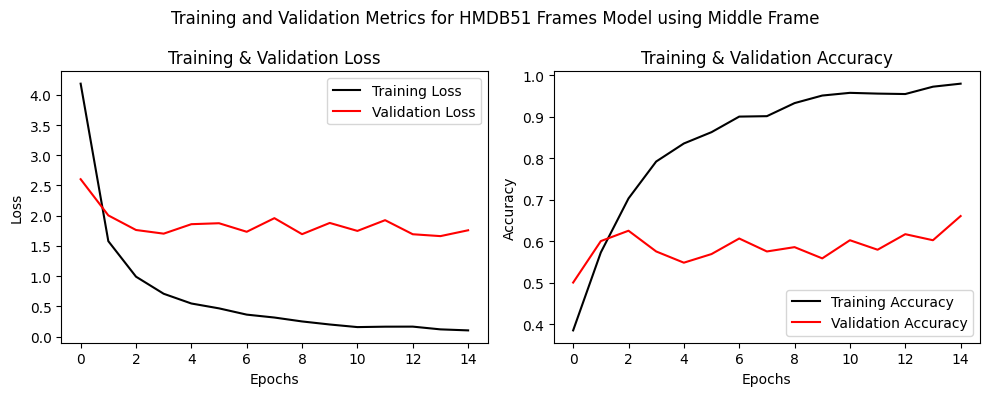

In [14]:
plot_train_val_metrics(history_spatial_hmdb51,
                       "HMDB51 Frames Model using Middle Frame", "results_spatial_hmdb51_middle.png")

### Plot learning rate during training

In [15]:
def plot_lr(lr_per_epoch, model_name="Model", file_name="lrs_model.png"):
    """
    Plots learning rates for every epoch and outputs to file.

    :param lr_per_epoch: learning rate for every epoch
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    # Plot learning rate
    plt.figure(figsize=(6, 4))
    plt.plot(lr_per_epoch)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(f"Adaptive Learning Rate During Training for {model_name}")

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

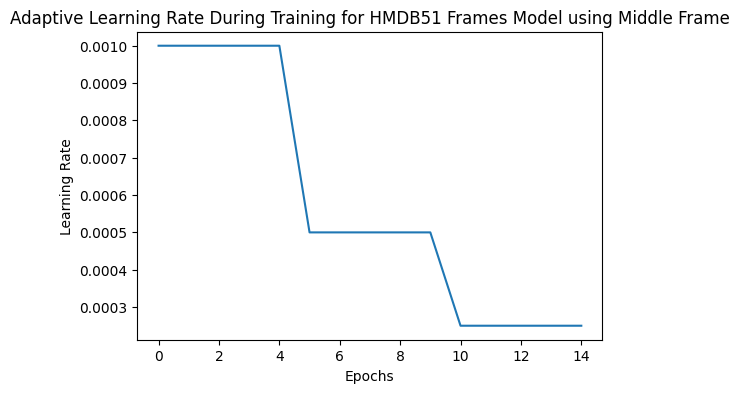

In [16]:
plot_lr(lrs_spatial_hmdb51, "HMDB51 Frames Model using Middle Frame", "lrs_spatial_hmdb51_middle.png")

### Export model

In [17]:
def export_model(model, model_name="model"):
    """
    Outputs model to file.

    :param model: model
    :param model_name: model name for output file name
    """
    # Export model to TorchScript
    model_scripted = torch.jit.script(model)

    # Save model
    os.makedirs("models", exist_ok=True)
    model_scripted.save(os.path.join("models", model_name + ".pt"))

In [18]:
export_model(spatial_hmdb51, "spatial_hmdb51_middle")

### Evalutate model on test set

In [19]:
def test_model_multiclass(model, num_classes, test_loader, device="cpu"):
    """
    Tests a trained multiclass classification model on test data.

    :param model: model
    :param num_classes: number of classes
    :param test_loader: test data loader
    :param device: device choice
    :return: returns test loss, test accuracy, predicted labels, and actual labels
    """
    # Define Loss Function
    loss_fn = nn.CrossEntropyLoss()
    # Define output accuracy function
    accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    # Move accuracy and model to the appropriate device
    accuracy = accuracy.to(device)
    model = model.to(device)

    test_loss, test_acc = 0, 0
    y_preds = []
    y_labels = []

    # Set model to evaluation mode
    model.eval()
    with torch.inference_mode():
        # Iterating over batches of test data
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass to compute predictions
            y_pred = model(X)

            # Calculate the current batch loss and accuracy and aggregate
            test_loss += loss_fn(y_pred, y).item()
            test_acc += accuracy(y_pred, y).item()

            # Store predictions and labels
            y_preds.extend(y_pred.argmax(dim=1).cpu().numpy())
            y_labels.extend(y.cpu().numpy())

        # Average test loss and accuracy over all batches
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

    return test_loss, test_acc, y_preds, y_labels

In [20]:
test_loss_spatial_hmdb51, test_acc_spatial_hmdb51, y_preds_spatial_hmdb51, y_labels_spatial_hmdb51 \
    = test_model_multiclass(spatial_hmdb51, len(action_categories), test_middle_loader, DEVICE)

Test loss:  2.95760| Test acc:  0.41667


### Plot confusion matrix

In [21]:
def plot_confusion_matrix(preds, labels, labels_map, model_name="Model", file_name="cm_model.png"):
    """
    Plots confusion matrix of predicted labels and actual labels and outputs to file.

    :param preds: predicted labels
    :param labels: actual labels
    :param labels_map: dictionary of labels mapped to numeric model labels
    :param model_name: model name for plot title
    :param file_name: output file name
    """
    # Extract label names based on mapping
    label_names = [label for label, idx in labels_map.items()]

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")
    plt.title(f"Confusion Matrix for {model_name}")

    # Save plot to file
    os.makedirs("plots", exist_ok=True)
    plt.savefig(os.path.join("plots", file_name), bbox_inches="tight", dpi=300)

    plt.show()

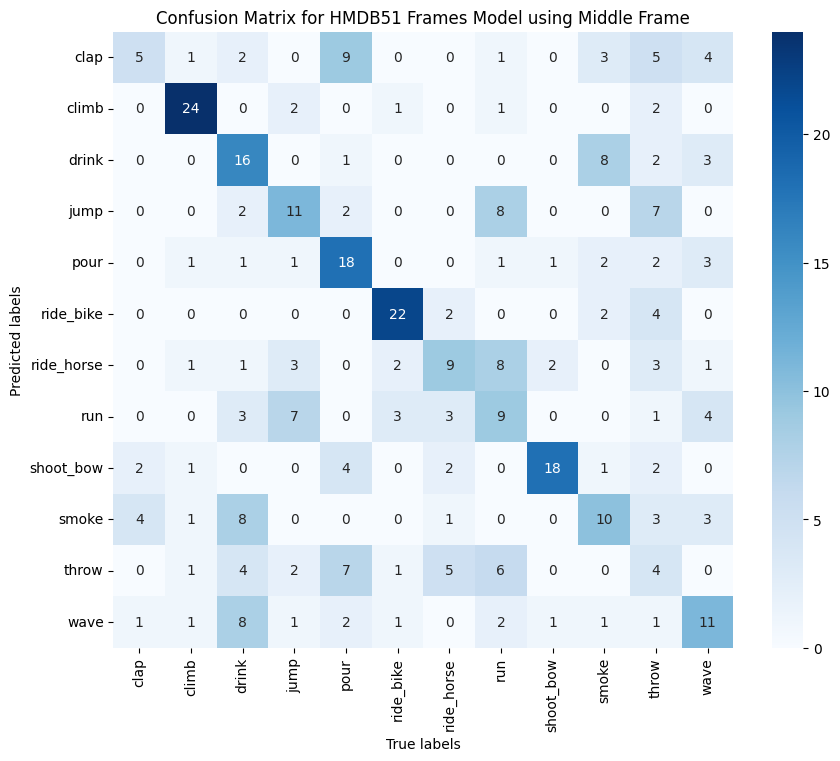

In [22]:
plot_confusion_matrix(y_preds_spatial_hmdb51, y_labels_spatial_hmdb51, action_categories_map,
                      "HMDB51 Frames Model using Middle Frame", "cm_spatial_hmdb51_middle.png")

## Load pre-trained model again, fine-tune it on first frame data, and evaluate it

### Import pre-trained model and freeze first layers for transfer learning

In [23]:
spatial_hmdb51_f = torch.jit.load(os.path.join("models", "spatial_stanford40_cyclical.pt"))

# Keep only some convolution layers and dense layer unfrozen
spatial_hmdb51_f = freeze_model_layers(spatial_hmdb51_f, trainable_layers=["layer2", "layer3", "layer4", "fc"])

### Train and validate model

In [24]:
spatial_hmdb51_f, history_spatial_hmdb51_f, lrs_spatial_hmdb51_f = train_model_multiclass(
    spatial_hmdb51_f, len(action_categories), train_first_loader, val_first_loader, DEVICE,
    EPOCHS, LEARNING_RATE, "step", LEARNING_RATE_ADAPT_STEP, LEARNING_RATE_ADAPT_GAMMA,
    tensorboard_tracking=TENSORBOARD_TRACKING, experiment_name="spatial_hmdb51", model_name="spatial_hmdb51_first"
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0| Train loss:  4.77090| Train acc:  0.33073| Val loss:  3.96638| Val acc:  0.41250
Epoch: 1| Train loss:  1.87623| Train acc:  0.52292| Val loss:  2.41485| Val acc:  0.40833
Epoch: 2| Train loss:  1.24431| Train acc:  0.64375| Val loss:  1.83971| Val acc:  0.47083
Epoch: 3| Train loss:  0.98689| Train acc:  0.69453| Val loss:  1.84357| Val acc:  0.44583
Epoch: 4| Train loss:  0.80487| Train acc:  0.75651| Val loss:  1.72933| Val acc:  0.46667
Epoch: 5| Train loss:  0.58133| Train acc:  0.81380| Val loss:  1.86898| Val acc:  0.46250
Epoch: 6| Train loss:  0.49263| Train acc:  0.84922| Val loss:  1.75362| Val acc:  0.39583
Epoch: 7| Train loss:  0.39702| Train acc:  0.87812| Val loss:  1.89383| Val acc:  0.43958
Epoch: 8| Train loss:  0.28699| Train acc:  0.91432| Val loss:  1.82924| Val acc:  0.44375
Epoch: 9| Train loss:  0.26239| Train acc:  0.93359| Val loss:  1.92340| Val acc:  0.53333
Epoch: 10| Train loss:  0.23594| Train acc:  0.93620| Val loss:  2.03429| Val acc:  0.4229

### Plot accuracy and loss for training and validation

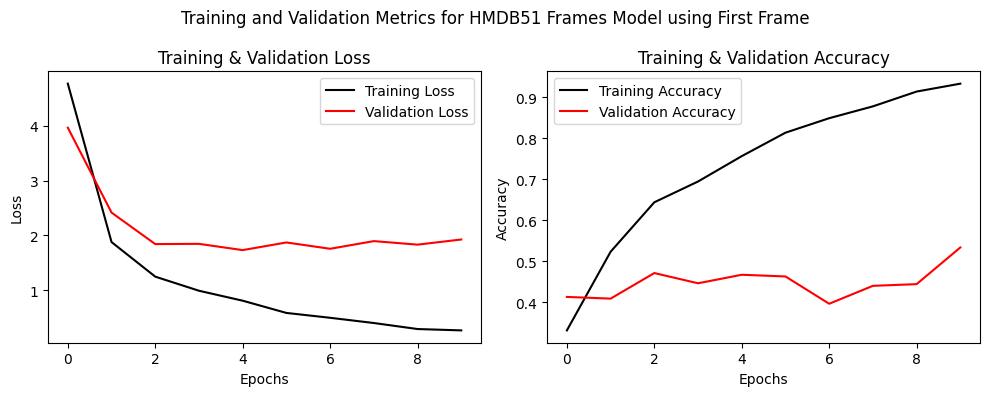

In [25]:
plot_train_val_metrics(history_spatial_hmdb51_f, "HMDB51 Frames Model using First Frame", "results_spatial_hmdb51_first.png")

### Plot learning rate during training

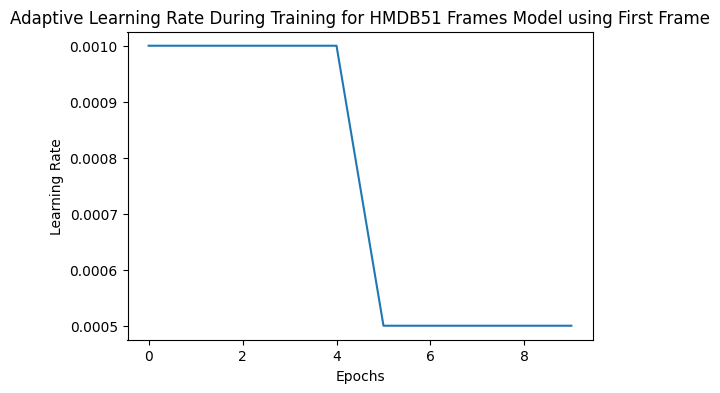

In [26]:
plot_lr(lrs_spatial_hmdb51_f, "HMDB51 Frames Model using First Frame", "lrs_spatial_hmdb51_first.png")

### Export model

In [27]:
export_model(spatial_hmdb51_f, "spatial_hmdb51_first")

### Evalutate model on test set

In [28]:
test_loss_spatial_hmdb51_f, test_acc_spatial_hmdb51_f, y_preds_spatial_hmdb51_f, y_labels_spatial_hmdb51_f \
    = test_model_multiclass(spatial_hmdb51_f, len(action_categories), test_first_loader, DEVICE)

Test loss:  4.18664| Test acc:  0.27344


### Plot confusion matrix

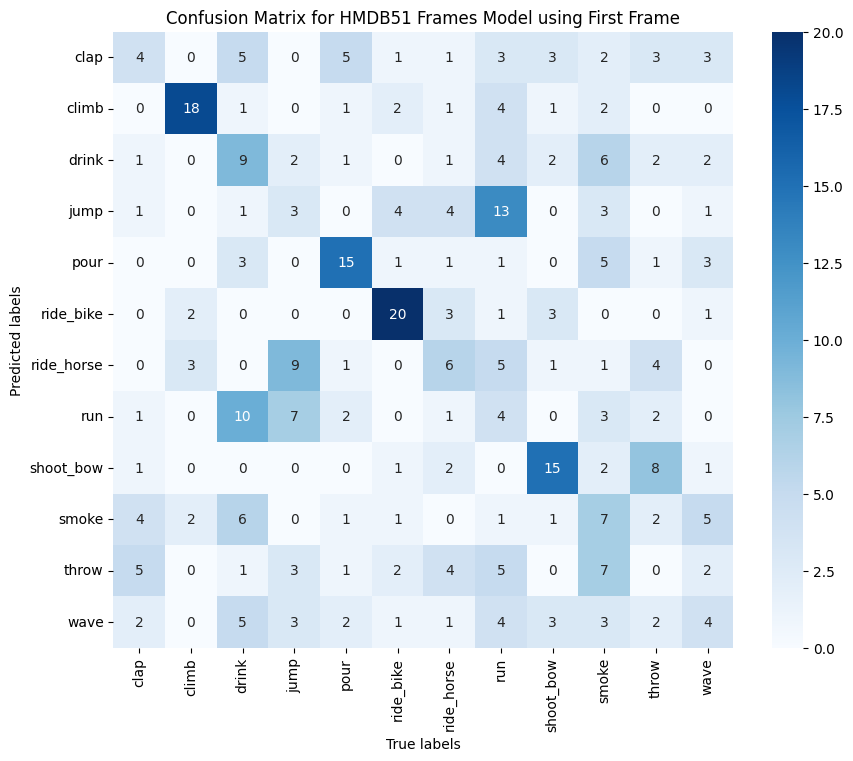

In [29]:
plot_confusion_matrix(y_preds_spatial_hmdb51_f, y_labels_spatial_hmdb51_f, action_categories_map,
                      "HMDB51 Frames Model using First Frame", "cm_spatial_hmdb51_first.png")

## Load pre-trained model again, fine-tune it on last frame data, and evaluate it

### Import pre-trained model and freeze first layers for transfer learning

In [30]:
spatial_hmdb51_l = torch.jit.load(os.path.join("models", "spatial_stanford40_cyclical.pt"))

# Keep only some convolution layers and dense layer unfrozen
spatial_hmdb51_l = freeze_model_layers(spatial_hmdb51_l, trainable_layers=["layer2", "layer3", "layer4", "fc"])

### Train and validate model

In [31]:
spatial_hmdb51_l, history_spatial_hmdb51_l, lrs_spatial_hmdb51_l = train_model_multiclass(
    spatial_hmdb51_l, len(action_categories), train_last_loader, val_last_loader, DEVICE,
    EPOCHS, LEARNING_RATE, "step", LEARNING_RATE_ADAPT_STEP, LEARNING_RATE_ADAPT_GAMMA,
    tensorboard_tracking=TENSORBOARD_TRACKING, experiment_name="spatial_hmdb51", model_name="spatial_hmdb51_last"
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0| Train loss:  4.96070| Train acc:  0.29427| Val loss:  3.79555| Val acc:  0.35417
Epoch: 1| Train loss:  1.84260| Train acc:  0.54479| Val loss:  2.87808| Val acc:  0.40208
Epoch: 2| Train loss:  1.30100| Train acc:  0.65234| Val loss:  2.30393| Val acc:  0.42917
Epoch: 3| Train loss:  0.89411| Train acc:  0.72396| Val loss:  2.07775| Val acc:  0.47500
Epoch: 4| Train loss:  0.66355| Train acc:  0.80156| Val loss:  2.15515| Val acc:  0.48333
Epoch: 5| Train loss:  0.53219| Train acc:  0.84453| Val loss:  2.07209| Val acc:  0.52500
Epoch: 6| Train loss:  0.45368| Train acc:  0.86693| Val loss:  1.88003| Val acc:  0.52083
Epoch: 7| Train loss:  0.40985| Train acc:  0.88776| Val loss:  2.06433| Val acc:  0.50833
Epoch: 8| Train loss:  0.31782| Train acc:  0.90521| Val loss:  2.09161| Val acc:  0.50625
Epoch: 9| Train loss:  0.24194| Train acc:  0.93568| Val loss:  2.15571| Val acc:  0.50833
Epoch: 10| Train loss:  0.23131| Train acc:  0.93802| Val loss:  2.27546| Val acc:  0.4937

### Plot accuracy and loss for training and validation

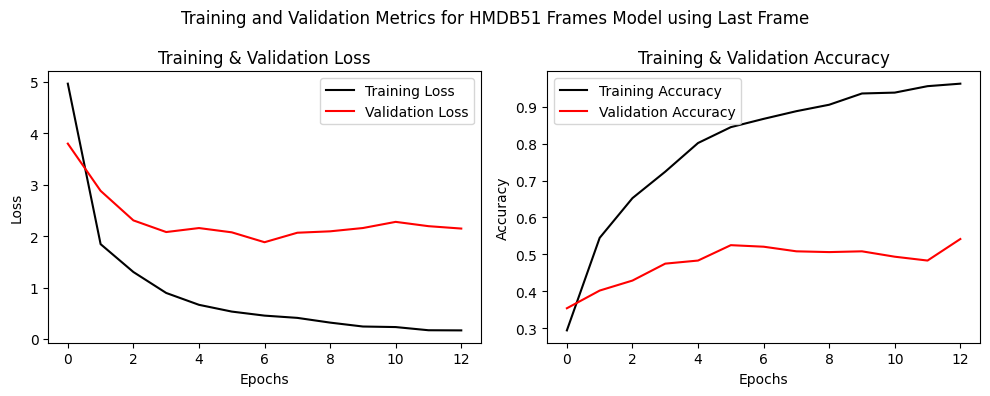

In [32]:
plot_train_val_metrics(history_spatial_hmdb51_l, "HMDB51 Frames Model using Last Frame", "results_spatial_hmdb51_last.png")

### Plot learning rate during training

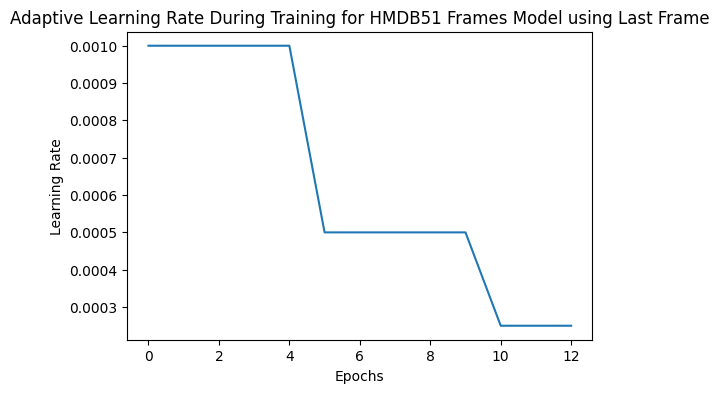

In [33]:
plot_lr(lrs_spatial_hmdb51_l, "HMDB51 Frames Model using Last Frame", "lrs_spatial_hmdb51_last.png")

### Export model

In [34]:
export_model(spatial_hmdb51_l, "spatial_hmdb51_last")

### Evalutate model on test set

In [35]:
test_loss_spatial_hmdb51_l, test_acc_spatial_hmdb51_l, y_preds_spatial_hmdb51_l, y_labels_spatial_hmdb51_l \
    = test_model_multiclass(spatial_hmdb51_l, len(action_categories), test_last_loader, DEVICE)

Test loss:  3.73809| Test acc:  0.32031


### Plot confusion matrix

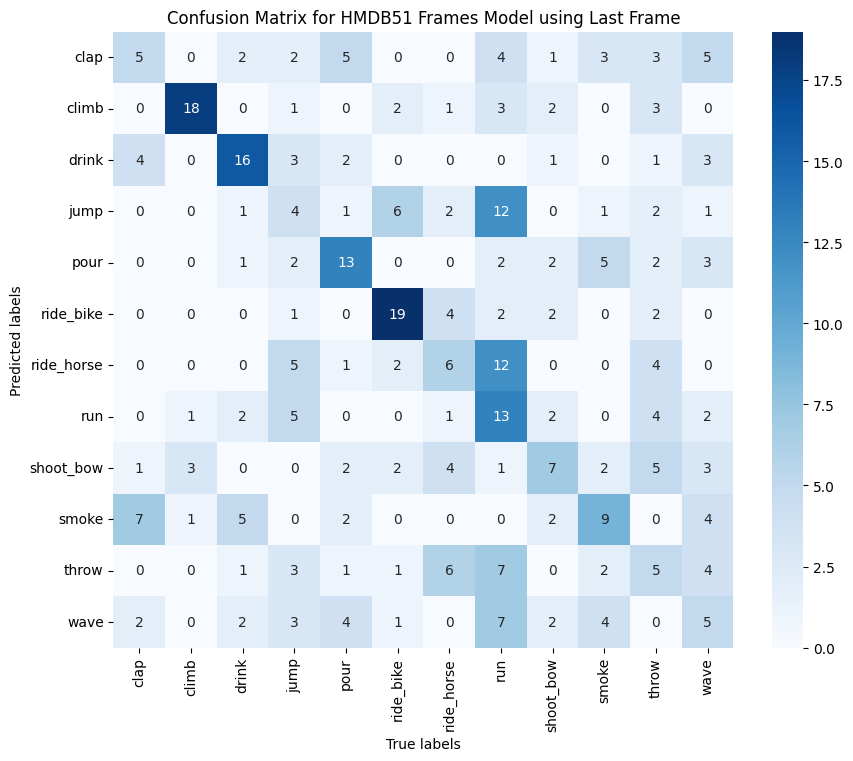

In [36]:
plot_confusion_matrix(y_preds_spatial_hmdb51_l, y_labels_spatial_hmdb51_l, action_categories_map,
                      "HMDB51 Frames Model using Last Frame", "cm_spatial_hmdb51_last.png")

## Save all model results

In [37]:
def export_model_metrics(model_metrics, file_name="metrics_model.csv"):
    """
    Outputs training, validation, and test results for multiple models to file.

    :param model_metrics: dictionary of dictionaries for every model with best epoch training and validation results
                          and final test results
    :param file_name: output file name
    """
    # Convert metrics to dataframe
    model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient="index")
    print(model_metrics_df)

    # Save dataframe
    os.makedirs("results", exist_ok=True)
    model_metrics_df.to_csv(os.path.join("results", file_name))

In [38]:
model_metrics = {
    "spatial_model_hmdb51_middle": {
        "train_loss": history_spatial_hmdb51["train_loss"][-1],
        "val_loss": history_spatial_hmdb51["val_loss"][-1],
        "train_acc": history_spatial_hmdb51["train_acc"][-1],
        "val_acc": history_spatial_hmdb51["val_acc"][-1],
        "test_loss": test_loss_spatial_hmdb51,
        "test_acc": test_acc_spatial_hmdb51
    },
    "spatial_model_hmdb51_first": {
        "train_loss": history_spatial_hmdb51_f["train_loss"][-1],
        "val_loss": history_spatial_hmdb51_f["val_loss"][-1],
        "train_acc": history_spatial_hmdb51_f["train_acc"][-1],
        "val_acc": history_spatial_hmdb51_f["val_acc"][-1],
        "test_loss": test_loss_spatial_hmdb51_f,
        "test_acc": test_acc_spatial_hmdb51_f
    },
    "spatial_model_hmdb51_last": {
        "train_loss": history_spatial_hmdb51_l["train_loss"][-1],
        "val_loss": history_spatial_hmdb51_l["val_loss"][-1],
        "train_acc": history_spatial_hmdb51_l["train_acc"][-1],
        "val_acc": history_spatial_hmdb51_l["val_acc"][-1],
        "test_loss": test_loss_spatial_hmdb51_l,
        "test_acc": test_acc_spatial_hmdb51_l
    }
}

export_model_metrics(model_metrics, "metrics_spatial_hmdb51.csv")

                             train_loss  val_loss  train_acc   val_acc  \
spatial_model_hmdb51_middle    0.101344  1.758713   0.979687  0.660417   
spatial_model_hmdb51_first     0.262385  1.923403   0.933594  0.533333   
spatial_model_hmdb51_last      0.166774  2.145299   0.962240  0.541667   

                             test_loss  test_acc  
spatial_model_hmdb51_middle   2.957601  0.416667  
spatial_model_hmdb51_first    4.186639  0.273438  
spatial_model_hmdb51_last     3.738089  0.320312  
